<a href="https://colab.research.google.com/github/Anku5hk/The_ML_Workflow/blob/master/Fast_ai_assignments/emotion_classifier_fastai_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMOTION CLASSIFIER 2

This notebook will load the trained model and extract faces from images and predict with the model.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from pathlib import Path
from matplotlib import pyplot as plt
import os
import cv2
import sys
import shutil
import re
from os import path

In [0]:
faces_fld = Path('/content/faces/')
!mkdir {faces_fld}
boxes_fld = Path('/content/labeled_boxes/')
!mkdir {boxes_fld}

In [0]:
def create_dataset():
  # download the data and unzip
  data_dir = Path.home()/".fastai/data/KDEF/"
  src_data_dir = data_dir/"KDEF_and_AKDEF"
  flat_dir = data_dir/"flat"
  !mkdir -p {flat_dir}
  zip_url = 'http://kdef.se/download/KDEF_and_AKDEF.zip'
  zip_file = data_dir/"kdef.zip"
  if not src_data_dir.exists():
      !wget -O {zip_file} {zip_url}
      !unzip {zip_file} -d {data_dir}

  # create a dataset folder to copy all imgs into a single folder
  dataset = data_dir/".dataset/"
  !mkdir -p {dataset}    

  # create dict for better understanding
  classes_dict = { 'AF' : 'Afraid',
                      'AN' : 'Angry',
                      'DI' : 'Disgusted',
                      'HA' : 'Happy',
                      'NE' : 'Neutral',
                      'SA' : 'Sad',
                      'SU' : 'Surprised'}
  classes = classes_dict.values()

  # make classes sub-folders
  train_path = Path('/content/data/train/')
  !mkdir -p {train_path}
  for cls in classes:
    class_fld = Path('/content/data/train/'+cls+'/')
    !mkdir -p {class_fld}
  !ls {train_path}

  # copy all imgs to 1 folder and fix some data mislabeling
  if not os.listdir(dataset):
      src_dir = src_data_dir/"KDEF"
      for fld in src_dir.iterdir():
          for img_file in fld.iterdir():
              imgs_dst = dataset.joinpath(img_file.name)
              os.link(img_file, imgs_dst)
      # Some files are misnamed, so fix them manually here
      rename_dict = {
          'AF31V': 'AF31SAHL',
          'AM31H': 'AM31SUHR',
      }
      for frm in rename_dict:
          to = rename_dict[frm]
          os.rename(dataset/(frm + ".JPG"), dataset/(to + ".JPG"))

  # get imgs
  fnames = get_image_files(dataset, check_ext=False)
  pat = r'\w{4}(\w{2})\w{1,2}\.JPG'

  # copy the images to respective class folder 
  data_path = '/content/data/train/'
  # to train/class*
  for fn in fnames:
      res = re.search(pat, fn.as_posix())
      class_id = res.group(1)
      img_name = res.group(0)
      new_img_path = data_path + classes_dict[class_id] +'/'+ img_name
      to = path.realpath(new_img_path) # to real path
      shutil.copyfile(fn,to)

  # remove unecessary folders
  shutil.rmtree(data_dir)
  print('Dataset Created Succesfully')    


In [0]:
def extract_faces(img_path):
  pat = r'(\w+)\.jpg'
  pat_str = re.search(pat, img_path)
  img_name =  pat_str.group(1)
  image = cv2.imread(img_path)
  # create a faceCascade object that will load the Haar Cascade file
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  # apply detectMultiScale() method on the faceCascade object. This generates list of rectangles for all faces in image.
  # this returns list co-ordinates of rectangles
  faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
  )
  print("Found {0} Faces!".format(len(faces)))  
  i = 0
  # draw rectangle around the face with co-ordinates found, also extract the faces found
  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
      roi_color = image[y:y + h, x:x + w] 
      i+=1
      face_name = img_name+'_face'+str(i)+'.jpg'    
      cv2.imwrite(face_name, roi_color)
      save_loc = path.realpath('/content/faces/'+ face_name)
      from_loc = path.realpath('/content/'+ face_name)
      shutil.move(from_loc,save_loc) 
  # save the image
  obj_img_name = img_name +'_labeled_faces.jpg'
  cv2.imwrite(obj_img_name, image)
  save_loc = path.realpath('/content/labeled_boxes/'+ obj_img_name)
  from_loc = path.realpath('/content/'+ obj_img_name)
  shutil.move(from_loc,save_loc)
  print('DONE')

In [0]:
# download and create a dataset
create_dataset()

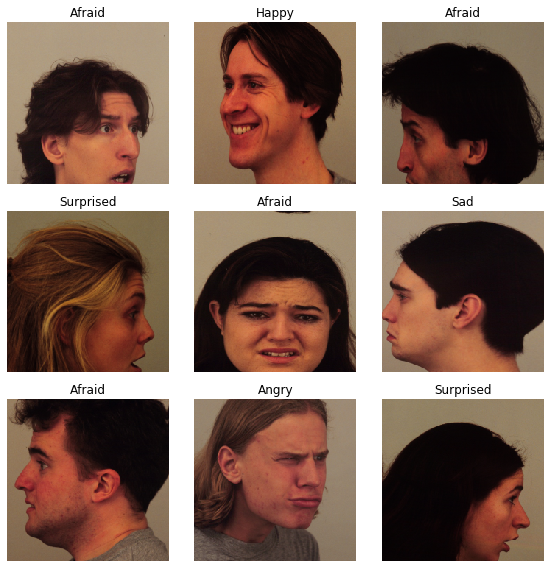

In [0]:
# create a dataset
tfms = get_transforms(max_zoom=1, max_rotate=10)
data_path = '/content/data/'
data = ImageDataBunch.from_folder(data_path, ds_tfms=tfms, seed=42, valid_pct=0.1,size=220, bs=12)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(8,8))

In [0]:
# ready/load model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.load('/content/drive/My Drive/ML_needs/res-50-3')

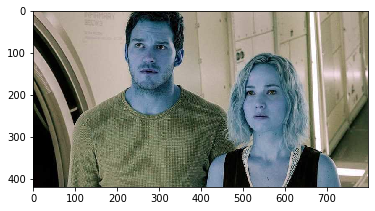

In [0]:
# test img
one_img = '/content/drive/My Drive/photos/pass.jpg'
image = cv2.imread(one_img)
plt.imshow(image)
plt.show()

In [0]:
# extract faces faces and save those as imgs ***add loop here
extract_faces('/content/drive/My Drive/photos/pass.jpg')

Found 2 Faces!
DONE


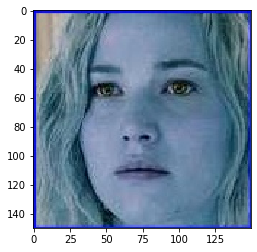

Category Sad

In [0]:
# predict on face
one_img = '/content/faces/pass_face2.jpg'
imgr = open_image(one_img)
preds = learn.predict(imgr)[0]
image = cv2.imread(one_img)
plt.imshow(image)
plt.show()
preds

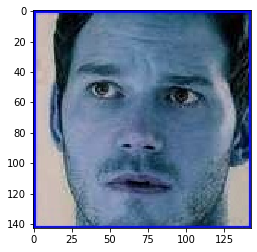

Category Afraid

In [0]:
one_img = '/content/faces/pass_face1.jpg'
imgr = open_image(one_img)
preds = learn.predict(imgr)[0]
image = cv2.imread(one_img)
plt.imshow(image)
plt.show()
preds